In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp

import scipy as osp

from numpy.polynomial.hermite import hermgauss

import paragami

# BNP sensitivity libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as preconditioner_lib
import bnpgmm_runjingdev.hessian_lib as hessian_lib

import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import time 

import json 

import scipy as osp

/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Load data

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

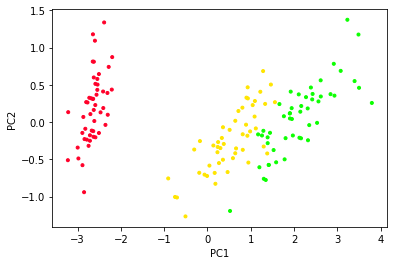

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Get prior

In [4]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = np.array([3.0])
print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'alpha': DeviceArray([3.], dtype=float64), 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


# Get VB params 

In [5]:
k_approx = 30

In [6]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

DeviceArray([1624.52172355], dtype=float64)

## Initialize 

In [9]:
# run a kmeans init
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 3445)
                                                
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
[6580.09503706]


In [10]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


Text(0, 0.5, 'PC2')

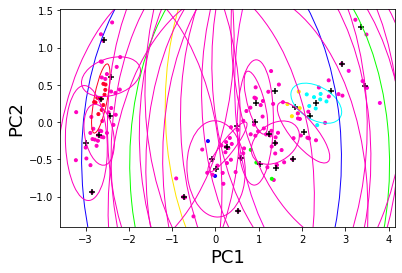

In [11]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, init_vb_params_dict, init_ez, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Run CAVI

In [12]:
vb_params_dict = deepcopy(init_vb_params_dict)

In [13]:
vb_opt_dict, e_z_opt = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False)

done. num iterations = 100
stick_time: 2.542sec
cluster_time: 1.017sec
e_z_time: 0.626sec
**TOTAL time: 7.747sec**


In [14]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [15]:
(vb_opt**2).mean()

DeviceArray(0.45070642, dtype=float64)

In [16]:
print('optimized kl: ')
print(gmm_lib.get_kl(features, vb_opt_dict, prior_params_dict, gh_loc, gh_weights))

optimized kl: 
[-388.28035483]


# Define objective

In [18]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = [vb_params_paragami, prior_params_paragami],
                                free = True,
                                argnums = [1, 2])


objective_fun = lambda x, y : get_vb_params_loss(features, x, y, gh_loc, gh_weights).squeeze()


In [21]:
def get_jac_hvp_fun(f):
    def hvp(x, v):
        return jax.jvp(jax.grad(f), (x, ), (v, ))[1]
    return hvp

In [22]:
# get derivative functions
obj_fun_grad = jax.jit(jax.grad(objective_fun, argnums = 0))
obj_fun_hessian = jax.jit(jax.hessian(objective_fun, argnums = 0))

obj_fun_hvp = jax.jit(get_jac_hvp_fun(lambda x : objective_fun(x, prior_params_free)))

# Derivative times

In [23]:
t0 = time.time()
loss = objective_fun(vb_opt, prior_params_free)
print('function time: {:0.3}sec'.format(time.time() - t0))

function time: 0.605sec


In [24]:
t0 = time.time()
grad = obj_fun_grad(vb_opt, prior_params_free)
print('gradient time: {:0.3}sec'.format(time.time() - t0))

gradient time: 8.68sec


In [25]:
%timeit obj_fun_grad(vb_opt, prior_params_free)

627 µs ± 38.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
# if its impossible, don't run the hessian
run_hessian = True

In [28]:
if run_hessian: 
    t0 = time.time()
    hess = obj_fun_hessian(vb_opt, prior_params_free)
    print('hessian compile time: {:0.3}sec'.format(time.time() - t0))

hessian time: 22.6sec


In [34]:
# after compiling, hessian time should be fast ... 
# %timeit obj_fun_hessian(vb_opt, prior_params_free)

In [35]:
t0 = time.time()
x = vb_opt
hvp = obj_fun_hvp(vb_opt, x)
print('hvp compile time: {:0.3}sec'.format(time.time() - t0))

hvp compile time: 33.0sec


In [36]:
%timeit obj_fun_hvp(vb_opt, x)

1.26 ms ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
# cross hessian 
hyper_obj_fun_grad = jax.jit(jax.jacobian(objective_fun, argnums=1))
hyper_obj_cross_hess = jax.jit(jax.jacobian(hyper_obj_fun_grad, argnums=0))

In [45]:
t0 = time.time()
cross_hess = hyper_obj_cross_hess(vb_opt, prior_params_free)
print('cross-hessian compile time: {:0.3}sec'.format(time.time() - t0))

cross-hessian compile time: 0.000534sec


In [46]:
%timeit hyper_obj_cross_hess(vb_opt, prior_params_free)

387 µs ± 31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [53]:
cross_hess = cross_hess.transpose()

# Solver times

### Solver without preconditioning

In [68]:
if run_hessian: 
    chol_solver = vittles.solver_lib.get_cholesky_solver(hess)
    
    t0 = time.time()
    dinput_dhyper = -chol_solver(cross_hess)
    
    print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 0.0011sec


In [69]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, x), 
                                            dim = len(vb_opt))
    
t0 = time.time()
cg_out = -cg_solver(cross_hess[:, 0])
    
print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 0.131sec


In [74]:
np.abs(dinput_dhyper[:, 0] -  cg_out).max()

DeviceArray(4.85739029e-06, dtype=float64)